# Lab 2: Bifurcations

## Problem 1 (4 points total)

You have been given signals of human brain activity obtained using an EEG.

The signal is received in two states - first, the subject solves a mathematical problem in his mind, then, having solved the problem, he stops thinking about anything :).

Your task is to find the bifurcation point in the brain activity of the subject - that is, the point at which the signal qualitatively changes its behavior.

In this case, it will be the point in time at which the person stopped solving the problem.

During this problem, you will be able to practice using Newton's method and searching for bifurcations on a one-dimensional problem, which will be very useful in the second task, which will be more difficult.

### Libraries

You are not allowed to use any other Python libraries except the ones listed below :(

In [1]:
import os.path as osp
from matplotlib import pyplot as plt
import numpy as np
from numba import njit
from scipy.stats import gaussian_kde
from scipy.ndimage import uniform_filter1d
from scipy.interpolate import interp1d

from tqdm.auto import trange, tqdm
from warnings import filterwarnings
filterwarnings('ignore')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read data

In [2]:
path = osp.join("Brain_EEG.npy")
power = np.load(path, allow_pickle=True)
sample_freq = 500.
print(f"Signal sampling frequency={sample_freq} Hz")
power.shape

Signal sampling frequency=500.0 Hz


(700, 79694)

Text(0.5, 1.0, 'Power map')

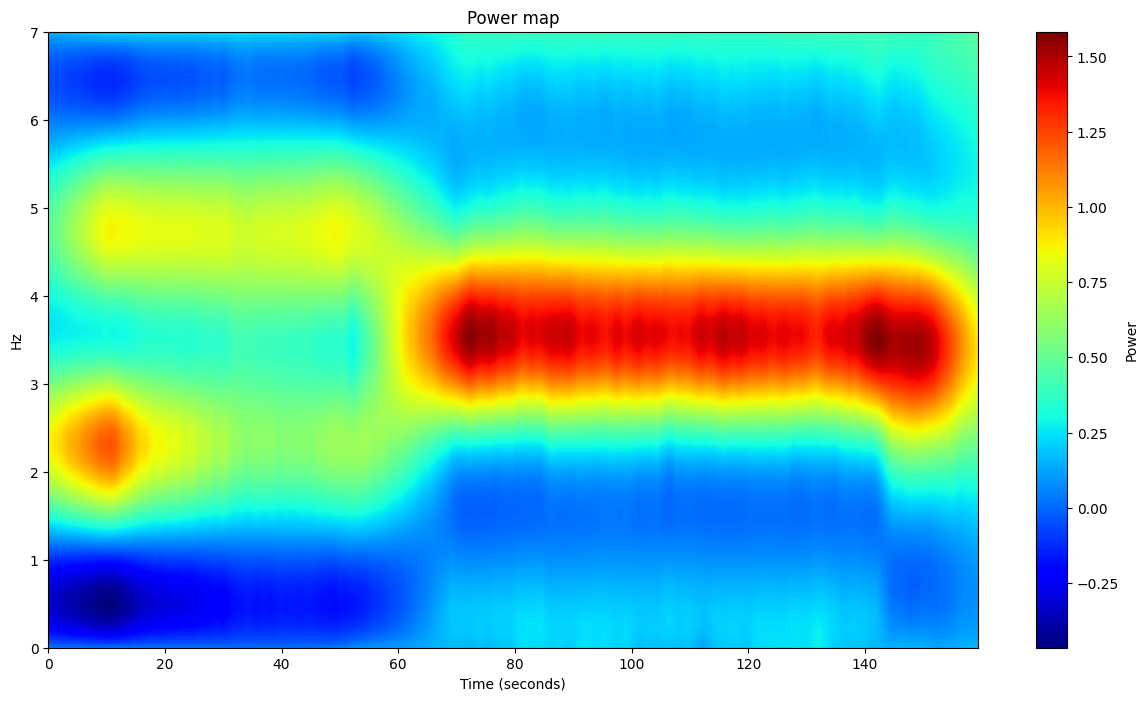

In [3]:
# Signal
omega, times = power.shape

omega_grid = np.linspace(0, 7, omega)

time_plot = np.arange(times) / sample_freq

plt.figure(figsize=(15, 8))
plt.imshow(
    power,
    aspect='auto',
    origin='lower',
    extent=[time_plot[0], time_plot[-1],
            omega_grid[0], omega_grid[-1]],
    cmap='jet'
)
plt.colorbar(label="Power")
plt.xlabel("Time (seconds)")
plt.ylabel("Hz")
plt.title("Power map")

### Problem 1.1 Let's look at the signal (1 point)

1. Implement a method for calculating the mean and variance of the signal frequency

2. Plot the signal power in the frequency domain, calculate the average and the variance of its frequency. To make the signal smoother, we will consider a window in the time domain, and average the signal power over time in this window. The choice of window width is yours.

Let's define formulas for mean and variance of the signal frequency

$\hat{x} = \frac{\sum{fx}}{\sum{x}}$

$var = \frac{\sum{f(x - \hat{x})^2}}{\sum{f}}$

In [5]:
@njit # you can remove, but it will work slower
def spectral_mean_std(
    omega_grid: np.ndarray, # (n_frequencies,)
    power_1d: np.ndarray, # (n_frequencies,)
):
    mean = np.sum(power_1d * omega_grid) / np.sum(power_1d)
    var = np.sum((power_1d * (omega_grid - mean) ** 2)) / np.sum(power_1d)
    print(var)
    std = np.sqrt(var)
    return mean, std

0.7224750488997415


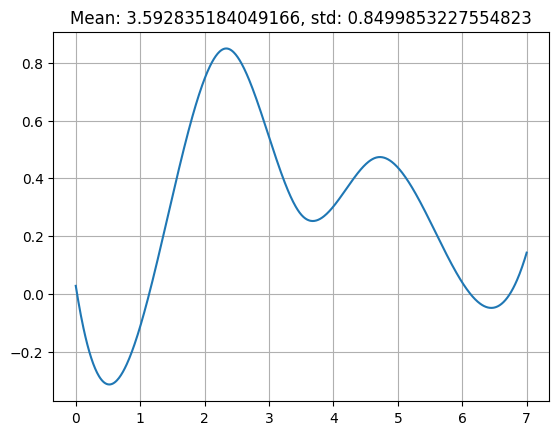

In [6]:
def plot_averaged_signal(
    power_1d: np.ndarray, # (n_frequencies, n_samples)
    window_size: int,
):
    omega, _ = power_1d.shape
    omega_grid = np.linspace(0, 7, omega)

    window_power = power_1d[:, :window_size]
    avg_power_in_window = np.mean(window_power, axis=1)
    mean, std = spectral_mean_std(omega_grid, avg_power_in_window)
    plt.plot(omega_grid, avg_power_in_window)
    plt.grid(True)
    plt.title(f"Mean: {mean}, std: {std}")


plot_averaged_signal(power, window_size=100)

### Problem 1.2  Search for signal parameters using the Newton method (1 point)

As you can see from your graph above (you can move the window to see how the signal behaves), the brain activity signal in the frequency domain resembles a combination of one or two Gaussians. Therefore, we will model it exclusively in this way.

In particular, your task is to take two Gaussians with averages $\omega_1, \omega_2$, and find these two parameters that minimize the deviation of the simulated signal from the real one using the Newton method. The variance for each Gaussian can be taken, for example, equal to the variance of the entire signal.

Your tasks:

1. Consider functional - square of the norm ($L_2 - norm$) of the deviation of model signal from the real one.
$$
    ||f(x)||_2^2 = \int_a^b f^2(x) \: dx, \quad x \in [a,b]
$$
$\quad$ In our problem, this functional is essentially just a function of two variables $\omega_1, \omega_2$, and for them it is an integral with two parameters. Accordingly, write down (in words or $\LaTeX$ formula) the necessary first-order local minimum conditions for it (relative to $\omega_1, \omega_2$).

2. These two conditions will be the boundary conditions for our task. Now, using Newton's method, find the frequencies that minimize the functional for our signal model

P.S. In order not to look for a constant by which the signal power is shifted relative to zero, you can simply subtract the average of its values at the edges from the signal.

#### You need to implement the Newton's method and all the necessary functions yourself! To do this, from the libraries you can use only `numpy`, `numba`.

First, to make sure that your implementation is correct, find the correct frequencies for the signal for which you know them.

Out normal funcs:

$G_1 = \frac{1}{\sigma \sqrt{2\pi}} \cdot e^{-\frac{(x - w_1)^2}{2 \sigma^2}}$

$G_2 = \frac{1}{\sigma \sqrt{2\pi}} \cdot e^{-\frac{(x - w_2)^2}{2 \sigma^2}}$

Singnal with normal funcs:

$G(x) = \frac{1}{\sigma \sqrt{2\pi}} \cdot e^{-\frac{(x - w_1)^2}{2 \sigma^2}}$ + $\frac{1}{\sigma \sqrt{2\pi}} \cdot e^{-\frac{(x - w_2)^2}{2 \sigma^2}}$

Real signal: $F(x)$

We need to minimize:

$f(x) = F(x) - G(x)$

$I = ||f(x)||_2^2 = \int_a^b (F(x) - G(x))^2\: dx, \quad x \in [a,b]$

Necessary first-order local minimum conditions:

$\frac{\partial{I}}{\partial{w_1}} = 0$

$\frac{\partial{I}}{\partial{w_2}} = 0$

$\frac{\partial{}}{\partial{w_1}} \int_a^b (F(x) - G(x))^2\: dx = \int_a^b \frac{\partial{}}{\partial{w_1}} (F(x) - G(x))^2\: dx = \int_a^b 2 \cdot (F(x) - G(x)) \frac{\partial{G(x)}}{\partial{w_1}}\: dx = 0 $

$\frac{\partial{}}{\partial{w_2}} \int_a^b (F(x) - G(x))^2\: dx = \int_a^b \frac{\partial{}}{\partial{w_2}} (F(x) - G(x))^2\: dx = \int_a^b 2 \cdot (F(x) - G(x)) \frac{\partial{G(x)}}{\partial{w_2}}\: dx = 0 $


$\frac{\partial{G(x)}}{\partial{w_1}} = \frac{\partial{G_1(x)}}{\partial{w_1}} = \frac{\partial{}}{\partial{w_1}}  \frac{1}{\sigma \sqrt{2\pi}} \cdot e^{-\frac{(x - w_1)^2}{2 \sigma^2}} = \frac{1}{\sigma \sqrt{2\pi}} \frac{\partial{}}{\partial{w_1}} e^{-\frac{(x - w_1)^2}{2 \sigma^2}} = \frac{1}{\sigma \sqrt{2\pi}}  e^{-\frac{(x - w_1)^2}{2 \sigma^2}} \cdot \frac{x - w_1}{\sigma^2} = G_1 \cdot \frac{x - w_1}{\sigma^2}$

$\frac{\partial{G(x)}}{\partial{w_2}} = \frac{\partial{G_2(x)}}{\partial{w_2}} = \frac{\partial{}}{\partial{w_2}}  \frac{1}{\sigma \sqrt{2\pi}} \cdot e^{-\frac{(x - w_2)^2}{2 \sigma^2}} = \frac{1}{\sigma \sqrt{2\pi}} \frac{\partial{}}{\partial{w_2}} e^{-\frac{(x - w_2)^2}{2 \sigma^2}} = \frac{1}{\sigma \sqrt{2\pi}}  e^{-\frac{(x - w_2)^2}{2 \sigma^2}} \cdot \frac{x - w_2}{\sigma^2} = G_2 \cdot \frac{x - w_2}{\sigma^2}$


In [7]:
@njit
def normalized_gaussian(omega, omega0, sigma):
    coef = 1.0 / (np.sqrt(2 * np.pi) * sigma)
    return coef * np.exp(-0.5 * ((omega - omega0) / sigma)**2)

@njit
def model_signal(omega, omega1, omega2, sigma):
    return normalized_gaussian(omega, omega1, sigma) + normalized_gaussian(omega, omega2, sigma)

@njit
def compute_F(omega_grid, y_true, omega1, omega2, sigma):
    """
    Calculte residuals
    """
    
    f_g = 2 * (model_signal(omega_grid, omega1, omega2, sigma) - y_true)

    G_1 = normalized_gaussian(omega_grid, omega1, sigma)
    dG_1 = G_1 * (omega_grid - omega1) / sigma ** 2

    G_2 = normalized_gaussian(omega_grid, omega2, sigma)
    dG_2 = G_2 * (omega_grid - omega2) / sigma ** 2

    return np.array([
        np.sum(f_g * dG_1) * (omega_grid[1] - omega_grid[0]),
        np.sum(f_g * dG_2) * (omega_grid[1] - omega_grid[0])
    ])

def approximate_jacobian(func, omega1, omega2, dx, omega_grid, y_true, sigma):
    """
    Calculate approximation of Jacobian
    """
    F = func(omega_grid, y_true, omega1, omega2, sigma)

    F_1 = (func(omega_grid, y_true, omega1 + dx, omega2, sigma) - F) / dx
    F_2 = (func(omega_grid, y_true, omega1, omega2 + dx, sigma) - F) / dx

    return np.array([
        [F_1[0], F_1[1]],
        [F_2[0], F_2[1]],
    ])

def newton_solver(omega_grid, y_true, omega1_init, omega2_init, sigma,
                  dx=1e-3, tol=1e-6, max_iter=1_000, verbose=True):
    """
    Implement Newton method to find optimal frequencies omega1, omega2
    """
    J = None
    omega1 = omega1_init
    omega2 = omega2_init

    for i in range(max_iter):
        F = compute_F(omega_grid, y_true, omega1, omega2, sigma)

        if verbose:
            print(f'iter {i} omega1: {omega1}, omega2: {omega2}. {np.linalg.norm(F)}')

        if np.linalg.norm(F) < tol:
            J = approximate_jacobian(compute_F, omega1, omega2, dx, omega_grid, y_true, sigma)
            if verbose:
                print(f'stop {i} omega1: {omega1}, omega2: {omega2}')
            break
        
        J = approximate_jacobian(compute_F, omega1, omega2, dx, omega_grid, y_true, sigma)

        res = np.linalg.solve(J, -F)

        omega1 += res[0]
        omega2 += res[1]

    return omega1, omega2, J

2.4099972060858557
iter 0 omega1: 2.9999999999999996, omega2: 3.9999999999999996. 2.5891470316515464
iter 1 omega1: 2.018437510428207, omega2: 4.981287523746219. 0.11573059339011278
iter 2 omega1: 1.9999788924337556, omega2: 5.000018764739016. 0.00012448843136714073
iter 3 omega1: 2.0000000000292957, omega2: 4.99999999996696. 1.9463894762567226e-10
stop 3 omega1: 2.0000000000292957, omega2: 4.99999999996696
mean: 3.4999999999999996, std: 1.5524165697665868
omega true: 2.0 5.0
omega pred: 2.0000000000292957 4.99999999996696


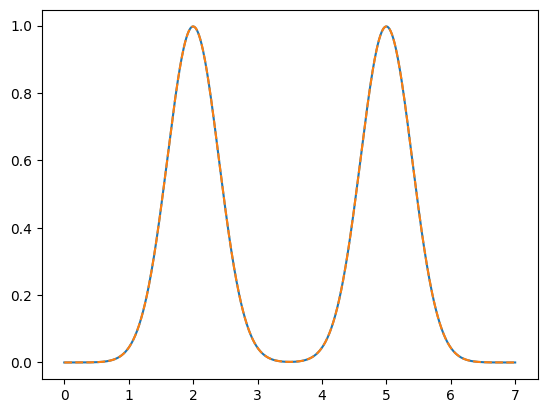

In [8]:
# Example
omega_example = np.linspace(0, 7, 700)

omega_1_test = 2.0
omega_2_test = 5.0
sigma = 0.4

y_true = model_signal(omega_example, omega_1_test, omega_2_test, sigma)

mu, std = spectral_mean_std(omega_example, y_true)

omega_1_fit, omega_2_fit, _ = newton_solver(
    omega_grid=omega_example,
    y_true=y_true,
    omega1_init=mu - 0.5,
    omega2_init=mu + 0.5,
    sigma=sigma,
    verbose=True
)

print(f'mean: {mu}, std: {std}')
print(f'omega true: {omega_1_test} {omega_2_test}')
y_pred = model_signal(omega_example, omega_1_fit, omega_2_fit, sigma)
print(f'omega pred: {omega_1_fit} {omega_2_fit}')

plt.plot(omega_example, y_true)
plt.plot(omega_example, y_pred, "--")

We see that we find correct params

#### Now for real signal

0.7232395052386027
mean: 3.596867884569953, std: 0.8504348918280592
iter 0 omega1: 2.596867884569953, omega2: 4.596867884569953. 0.23134992084021622
iter 1 omega1: 2.367152232890114, omega2: 4.624919679244323. 0.016316817474818373
iter 2 omega1: 2.384011077451284, omega2: 4.63337685593556. 3.3574762536963125e-05
iter 3 omega1: 2.384038877824797, omega2: 4.633364694528528. 2.8983471917213133e-09
stop 3 omega1: 2.384038877824797, omega2: 4.633364694528528
omega1 = 2.384038877824797, omega2=4.633364694528528


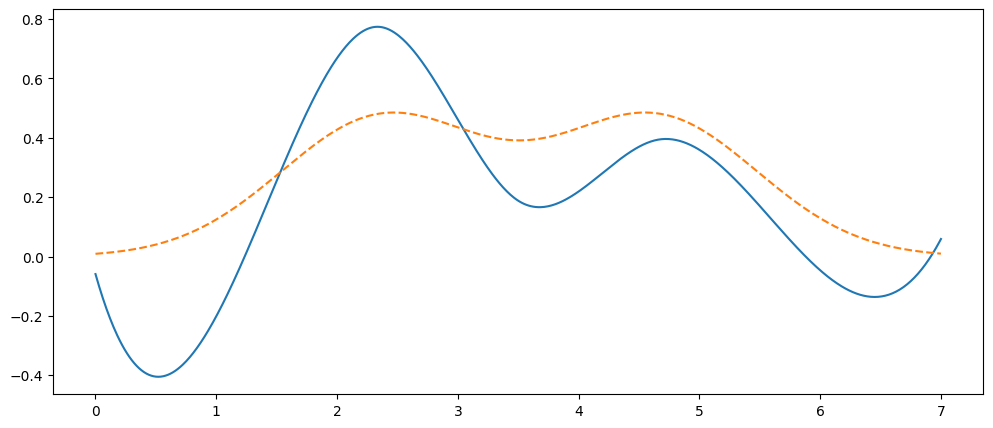

In [ ]:
# TODO
omega, _ = power.shape
omega_grid = np.linspace(0, 7, omega)
window_power = power[:, :300]
avg_power_in_window = np.mean(window_power, axis=1)

mean, std = spectral_mean_std(omega_grid, avg_power_in_window)

print(f'mean: {mean}, std: {std}')

to_delete = (avg_power_in_window[0] + avg_power_in_window[-1]) / 2
avg_power_in_window -= to_delete

omega_1_fit, omega_2_fit, _ = newton_solver(
    omega_grid=omega_grid,
    y_true=avg_power_in_window,
    omega1_init=mean - 1.0,
    omega2_init=mean + 1.0,
    sigma=std,
    verbose=True
)

print(f'omega1 = {omega_1_fit}, omega2={omega_2_fit}')

y_pred = model_signal(omega_grid, omega_1_fit, omega_2_fit, std)
plt.figure(figsize=(12,5))
plt.plot(omega_grid, avg_power_in_window)
plt.plot(omega_grid, y_pred, "--")


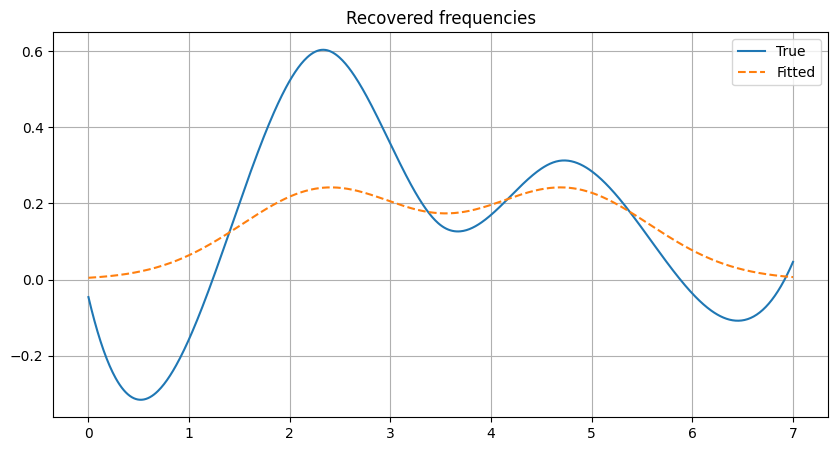

In [ ]:
# Example

### Problem 1.3 (1 point)

In Newton's method, you considered the Jacobian approximation. Now, moving the window along the signal, plot the absolute values of determinants of the found Jacobians. Again, use only `numpy`, `numba`

0.7224750488997415
0.7224029117908285
0.7223329452117921
0.7222651639658321
0.7221995820372172
0.7221362125762165
0.7220750678842429
0.7220161593992342
0.721959497681292
0.721905092398605
0.7218529523136734
0.7218030852698653
0.7217554981783293
0.7217101970052804
0.7216671867596789
0.7216264714813247
0.7215880542294002
0.7215519370714624
0.7215181210729222
0.7214866062870278
0.7214573917453659
0.7214304754489186
0.7214058543596659
0.7213835243927873
0.7213634804094656
0.7213457162102954
0.721330224529354
0.7213169970289256
0.721306024294888
0.7212972958328122
0.7212908000647762
0.7212865243268702
0.7212844548674691
0.7212845768462355
0.7212868743339128
0.7212913303128237
0.7212979266782291
0.7213066442404128
0.7213174627276132
0.7213303607897389
0.7213453160029103
0.7213623048748257
0.7213813028509486
0.7214022843215272
0.7214252226294409
0.7214500900788685
0.7214768579448061
0.7215054964833775
0.7215359749430127
0.721568261576432
0.7216023236534684
0.721638127474703
0.721675638385947


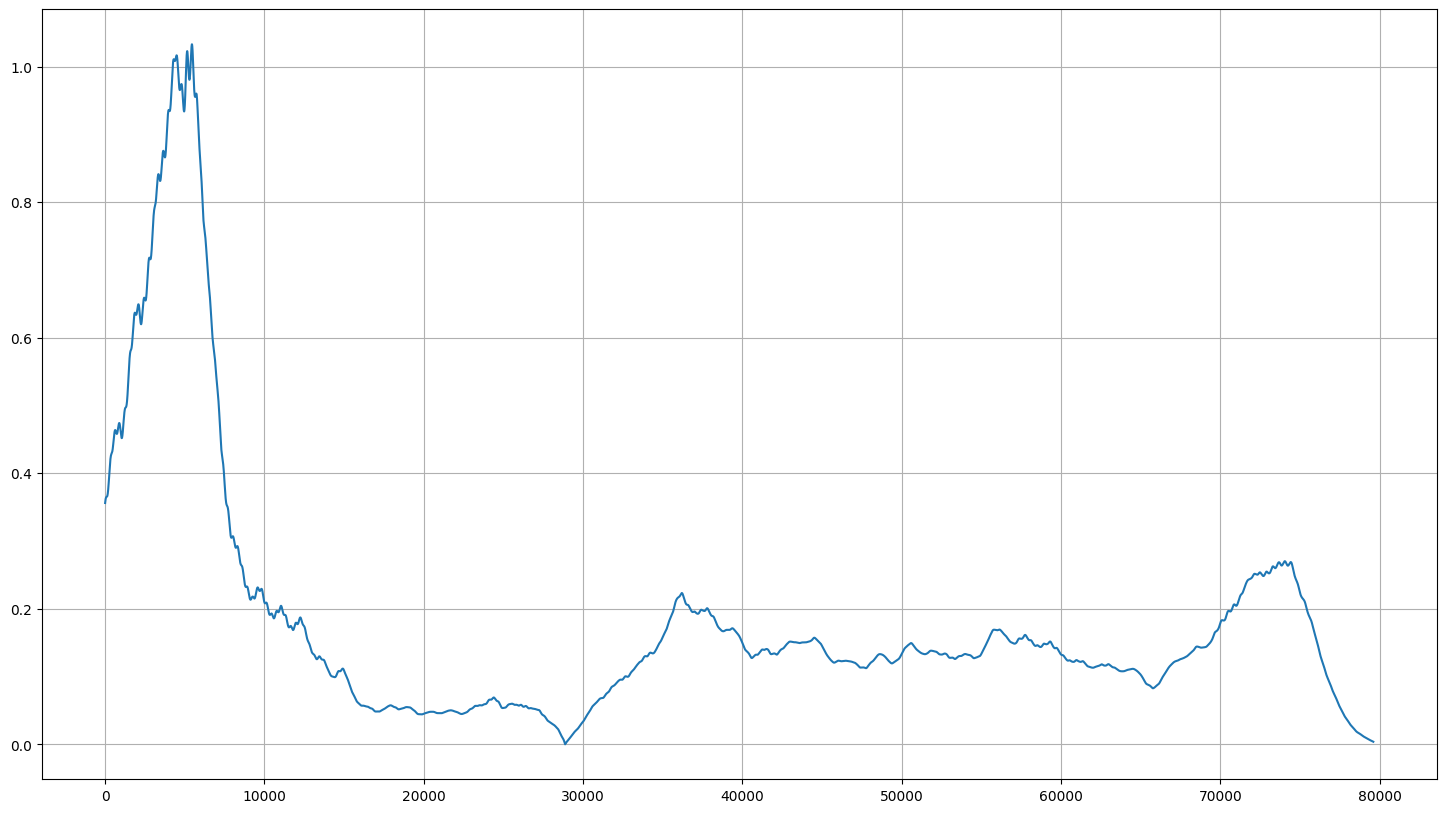

In [10]:
# Example
jacobians = list()
q = []
window_size = 100
prev = 0
omega_grid = np.linspace(0, 7, omega)
omega_1_fit = 2.0
omega_2_fit = 5.0

for t in range(79694 - window_size):
    window_power = np.mean(power[:, t:t + window_size], axis=1)

    mean, std = spectral_mean_std(omega_grid, window_power)

    to_delete = (window_power[0] + window_power[-1]) / 2
    window_power -= to_delete

    omega_1_fit, omega_2_fit, Matr = newton_solver(
            omega_grid=omega_grid,
            y_true=window_power,
            omega1_init=omega_1_fit,
            omega2_init=omega_2_fit,
            sigma=std,
            verbose=False
    )
    d = np.abs(np.linalg.det(Matr))
    jacobians.append(d)
    q.append(t)


plt.figure(figsize=(18,10))
plt.grid(True)
plt.plot(q, jacobians)


#### As you can see, the determinant reaches zero for the first time at some point.

(not exactly zero, but since we are approximating the Jacobian, we can assume that at the moment when the determinant reached the lowest value and began to increase back, it actually reached zero)

This point will be the bifurcation point, according to the theory of bifurcations.

We see bifurcation point at ~28.000 time moment

Now let's explore only that part:

1.2450505712298663
1.2450364187125074
1.2450218414757828
1.2450068257517044
1.2449913579591256
1.2449754247033755
1.2449590127759005
1.2449421091538453
1.244924700999664
1.2449067756607046
1.244888320668843
1.2448693237400907
1.244849772774293
1.2448296558547993
1.2448089612482343
1.2447876774042845
1.244765792955587
1.2447432967176277
1.2447201776887933
1.2446964250504482
1.2446720281671273
1.2446469765868542
1.2446212600415174
1.2445948684473918
1.2445677919057916
1.2445400207038217
1.2445115453152973
1.2444823564017728
1.244452444813733
1.2444218015919404
1.2443904179689054
1.244358285370564
1.2443253954180455
1.244291739929695
1.2442573109231707
1.2442221006177583
1.2441861014368387
1.2441493060105304
1.2441117071784986
1.2440732979929452
1.2440340717217764
1.2439940218519145
1.2439531420928351
1.2439114263802298
1.2438688688798396
1.243825463991463
1.243781206353119
1.2437360908453379
1.2436901125956492
1.243643266983162
1.2435955496433435
1.2435469564728747
1.2434974836346977
1.2

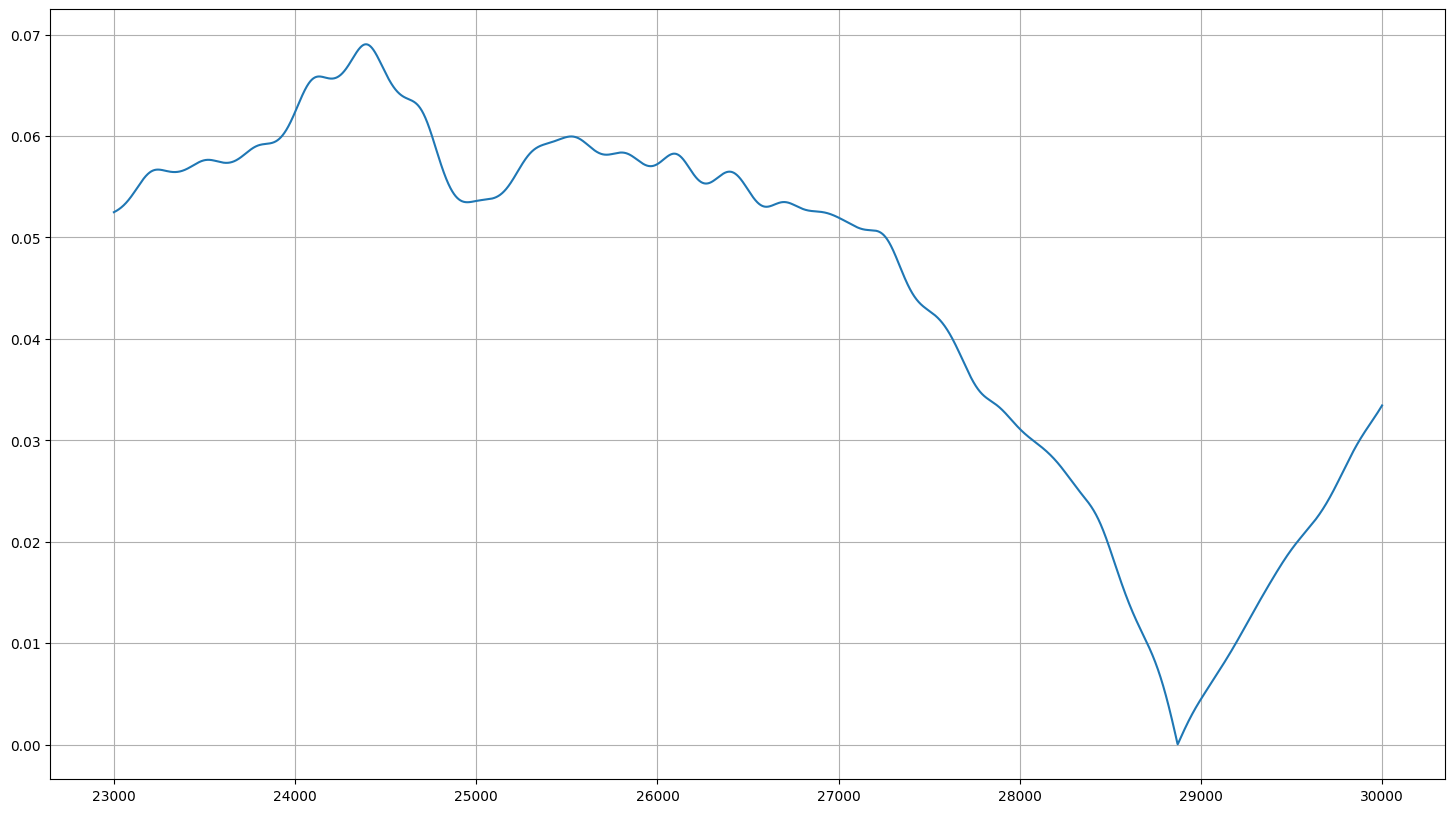

In [11]:
# Example
jacobians = list()
q = []
window_size = 100
prev = 0
omega_grid = np.linspace(0, 7, omega)
omega_1_fit = 2.0
omega_2_fit = 5.0

for t in range(23000, 30000):
    window_power = np.mean(power[:, t:t + window_size], axis=1)

    mean, std = spectral_mean_std(omega_grid, window_power)

    to_delete = (window_power[0] + window_power[-1]) / 2
    window_power -= to_delete

    omega_1_fit, omega_2_fit, Matr = newton_solver(
            omega_grid=omega_grid,
            y_true=window_power,
            omega1_init=omega_1_fit,
            omega2_init=omega_2_fit,
            sigma=std,
            verbose=False
    )
    d = np.abs(np.linalg.det(Matr))
    jacobians.append(d)
    q.append(t)


plt.figure(figsize=(18,10))
plt.grid(True)
plt.plot(q, jacobians)


#### Problem 1.4 Plot the signal power in the frequency domain before, at, and after the bifurcation point. Draw conclusions. (1 point)

1.3604072714769204
1.4312949816726668
1.7576275688231735


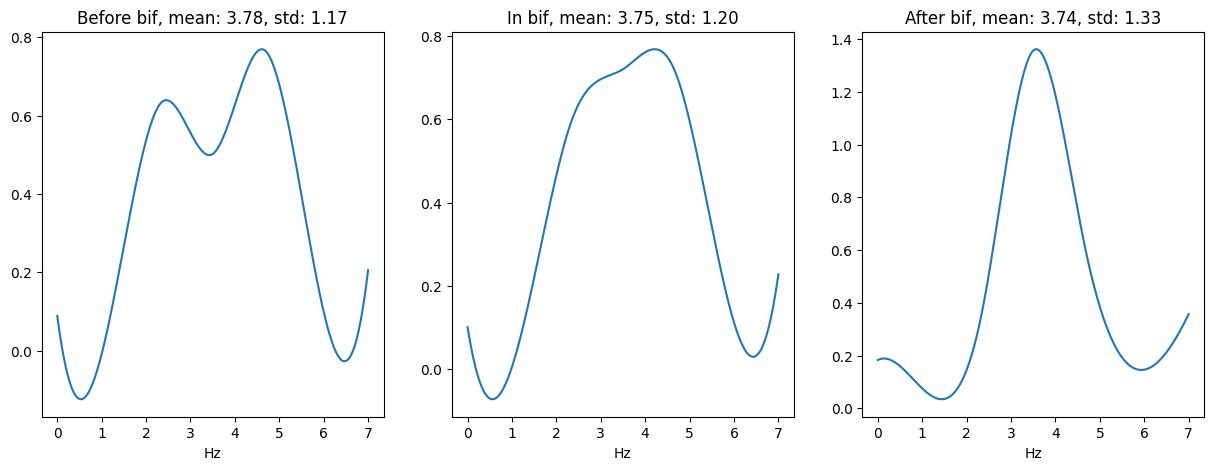

In [12]:
# TODO
periods = [28500, 30000]

windows = [
    (27000, periods[0]),
    (periods[0], periods[1]),
    (periods[1], 47000)
]
i = 0
plt.figure(figsize=(15, 5))

title = ["Before bif", "In bif", "After bif"]
for start, end in windows:
    power_window = np.mean(power[:, start:end], axis=1)
    mean, std = spectral_mean_std(omega_grid, power_window)

    plt.subplot(1, 3, i + 1)
    plt.plot(omega_grid, power_window)
    plt.title(f'{title[i]}, mean: {mean:.2f}, std: {std:.2f}')
    plt.xlabel("Hz")
    i += 1

At first plot we see 2 "gauss", similar behavior to original plot of signal (where was 2 "yellow" parts)

In bif point "gauss" "merging" in one "gauss" - it is behavior changing of function 

After bif point we got only one "gauss" - like in original signal

#### P.S. You should obtain something like this

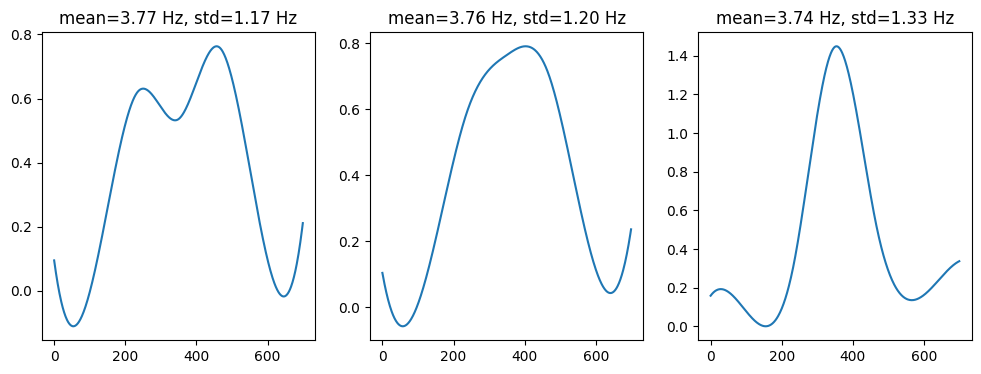

In [ ]:
# Пример работы

## Problem 2: 2D Bratu problem (6 points total)

You have been given a two-dimensional Bratu problem (yes, the one from the seminars):

$$\int_0^1 \int_0^1 \lambda e^u - \frac{1}{2} \left(\left(\frac{\partial u}{\partial x}\right)^2 + \left(\frac{\partial u}{\partial y}\right)^2\right) dxdy \longrightarrow \underset{u}{extr}$$
$$s.t.$$
$$u(0,y)=u(1,y)=u(x,0)=u(x,1)=0$$


1. (2 points) Using the generalised iterative Kantorovich method (it can be used with one term - $u(x,y) = h(x)g(y)$), solve the problem for $\lambda = 1$.
2. (4 points) Conduct bifurcation analysis for the Bratu problem. So, you need to construct two plots:
   1. $\lambda$ vs. determinant of the Jacobian matrix
   2. $\lambda$ vs. $\|u\|_\infty$

**P.S.**

You should have one critical point around $\lambda \approx 7.0$

**P.P.S.**

To simplify your task, instead of $e^u$, you can substitute its expansion in the Taylor series up to the third term: $e^u\approx 1 + u +\frac{u^2}{2!} + \frac{u^3}{3!}$. But then the critical point can shift. We will not reduce points for such a substitution!